# Electrochemical Impedance Spectroscopy Fitting of Lithium-Ion Batteries
This project aims to create a code for the Electrochemical Impedance Spectroscopy (EIS) fitting for Lithium-Ion Batteries (LIBs), using python package $\textit{impedance.py}$. This method will be compared with a standard methodology, based on the extended writing of the EIS equation and minimizing the residuals with the experimental points.
<img src='eis_scheme.jpg' alt= “mypic” width="500" height="250">

## Define the imports
The following libraries and packages will be uploaded for this script:
* $\textit{numpy}$: for numerical computing, including arrays operations;
* $\textit{matplotlib}$: for data visialization;
    * $\textit{pyplot}$: sub-module for creating and customizing plots;
    * $\textit{gridspec}$: sub-module for a flexible grid layout for arranging subplots within a figure;
* $\textit{scipy}$: for numerical optimization, integration, interpolation, etc.;
    * $\textit{leastsq}$: sub-module for performing the Levenberg-Marquardt optimization algorithm, which is commonly used for solving nonlinear least squares problems;
* $\textit{impedance}$: for analyzing electrochemical impedance spectroscopy data;
    * $\textit{preprocessing}$: sub-module for preprocessing impedance data from instrument files;
    * $\textit{models.circuits}$: sub-module for creating and fitting different circuit models to impedance data;
* $\textit{os}$: for working with files and directories, managing processes, and create folder.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.optimize import leastsq
from impedance import preprocessing
from impedance.models.circuits import CustomCircuit
import os

## Loading of experimental data
The experimental data are presented, usually, in the form of a 3-columns matrix:

$$
  M = 
  \begin{bmatrix}
    f\:[Hz] & Re(Z)\:[\Omega] & -Im(Z)\:[\Omega] \\
    ... & ... & ...
  \end{bmatrix}
$$

where Z is the complex number that represent EIS for each frequency point:

$$Z=Re(Z)-i\cdot Im(Z)$$

### Generation of data
With the $\textit{impedance}$ package, it is possible to (i) read and preprocessing data from different file, (ii) simulate an EIS with electrical circuit, (iii) operate a fit of the data by directly introducing the electric circuit as input, and (iv) create Nyquist and Bode diagrams. Since, at the moment, we do not have any experimental data to upload, we proceed to the generation of simulated data using the $\textit{impedance}$ package. Thanks to this module, a string representing the circuit for the electrical analogy can be used to create the function of the circuit itself. 
For instance, the string for the simulation can be:

$$\mbox{circuit_string = 'R0-p(R1,CPE1)-p(R2-Wo1,CPE2)'}$$

<img src="impedance-spectra.png" alt= “mypic” width="800" height="400">

Analytically, it can be translated into:

$$R_0+\frac{R_1}{1+(j2\pi f)^{\alpha_1} \tau_1}+\frac{R+W}{1+(j2\pi f)^{\alpha_2} \tau_2}$$

where

$$\tau_1 = R_1C_1$$

$$\tau_2 = (R_2+W)C_2$$

$$W = \frac{\sigma}{\sqrt{2\pi f}}+\frac{\sigma}{j\sqrt{2\pi f}}$$

Here, $\sigma$ is the Warburg element.

The model above was chosen as representative of most of the LIBs EIS literature. However, $\textit{impedance}$ allows you to build infinite circuits starting from the basic parameters (R, C, L, CPE, W), without having to go through the analytical function of the electric circuit. This makes python decidedly superior in terms of programming simplicity compared to MATLAB, where the NLLS fit function requires more care, expecially when dealing with complex numbers.

Now, simulated data can be generated, adding some noise.
Finally, two arrays are created by extrapolating the individual columns from the original matrix, in order to process the data and write them in order to plot Nyquist and Bode diagrams. The two vectors are the real and imaginary part of Z.

In [2]:
# When real data will be available, this block will be useless

# Representative string for the electric circuit
circuit_string = 'R0-p(R1,CPE1)-p(R2-Wo1,CPE2)'

# Inizialization of the generated parameters in the string
params_gen = [2,20, 1, .9, 100, .5, 10, 0.001, 0.9]

# Evaluation of the circuit with generated parameters
circuit = CustomCircuit(circuit_string, initial_guess=params_gen)

# Generated frequency values
f_gen = np.logspace(-3, 6, 50)

# Simulated EIS data
Z_gen = circuit.predict(f_gen)

# Add random noise to the simulated data
noise_amplitude = 0.05
noise_re = noise_amplitude * np.random.randn(len(f_gen))
noise_im = noise_amplitude * np.random.randn(len(f_gen))
Z_gen_noise = Z_gen + noise_re + 1j*noise_im

# Calculate real and imaginary part of Z
Z_real_gen = Z_gen_noise.real
Z_imag_gen = Z_gen_noise.imag

# For future application _gen == _exp
f_exp = f_gen
Z_exp = Z_gen_noise
Z_real_exp = Z_real_gen
Z_imag_exp = Z_imag_gen

C:\Users\strad_bx3\anaconda3\lib\site-packages\impedance\models\circuits\circuits.py:145: UserWarning: Simulating circuit based on initial parameters
  warnings.warn("Simulating circuit based on initial parameters")
C:\Users\strad_bx3\anaconda3\lib\site-packages\impedance\models\circuits\elements.py:170: RuntimeWarning: overflow encountered in tanh
  Z = Z0 / (np.sqrt(1j * omega * tau) * np.tanh(np.sqrt(1j * omega * tau)))


Nyquist and Bode diagrams are built in order to visualize the experimental data. To do this, the magnitude and phase of the impedance must also be calculated:

In [3]:
# Generation of module and phase of simulated data
mod_exp = np.abs(Z_exp)
ph_exp = np.angle(Z_exp)

# normalized frequency vector for Bode plot
f_exp_log = np.log(f_exp)/np.log(10)

At this point, it is possible to plot all the graphs!

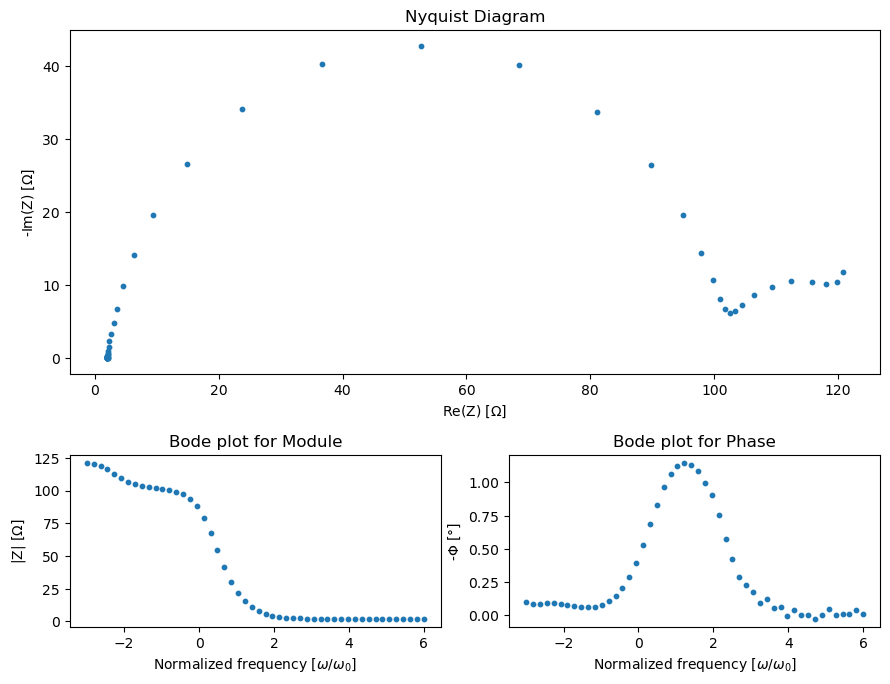

In [4]:
fig = plt.figure(figsize=(9, 9))
gs = gridspec.GridSpec(3, 2, height_ratios=[3, 1.5, 1.5], width_ratios=[1, 1])

# Nyquist Diagram
fig1 = fig.add_subplot(gs[0, :])
fig1.scatter(Z_real_exp, -Z_imag_exp, marker='o', s=10)
fig1.set_title('Nyquist Diagram')
fig1.set_xlabel('Re(Z) [$\Omega$]')
fig1.set_ylabel('-Im(Z) [$\Omega$]')

# Bode plot for Module
fig2 = fig.add_subplot(gs[1, 0])
fig2.scatter(f_exp_log, mod_exp, marker='o', s=10)
fig2.set_title('Bode plot for Module')
plt.xlabel('Normalized frequency [$\omega/\omega_0$]')
plt.ylabel('|Z| [$\Omega$]')

# Bode plot for Phase
fig3 = fig.add_subplot(gs[1, 1])
fig3.scatter(f_exp_log, -ph_exp, marker='o', s=10)
fig3.set_title('Bode plot for Phase')
plt.xlabel('Normalized frequency [$\omega/\omega_0$]')
plt.ylabel('-$\Phi$ [°]')

fig.tight_layout()
plt.show()

In this case, we have generated the experimental data, so we know exactly what is the electric model. However, the visualization of the data through Nyquist and Bode graphs is fundamental, given that, only in this way, it is possible to choose the function that can best approximate the experimental data.

### Function for the loading
In this section,  an initial function is proposed to upload experimental data once available. The following function reads data from the most common types of impedance files, in order to prevent compatibility problems between different files. The files must be in the same folder as the code. An error message is also expected in case the file does not exist, the name is misspelled, or a file with a different extension is uploaded.

In [5]:
def readFile(path_file, instrument=None):
    ''' 
    Function for reading the three most common types of impedance files

    INPUT: filename: filename to extract impedance data from
           instrument: type of instrument file

    OUTPUT: frequencies: array of frequencies
            impedance: array of complex impedances
    '''

    supported_types = ['biologic','versastudio']

    if instrument is not None:
        assert instrument in supported_types,\
            '{} is not a supported instrument ({})'.format(instrument,supported_types)
    elif instrument == 'biologic':
        f, Z = preprocessing.readBioLogic(path_file)
    elif instrument == 'versastudio':
        f, Z = preprocessing.readVersaStudio(path_file)
    elif instrument is None:
        f, Z = preprocessing.readCSV(path_file)
    return f, Z

# For example
# Provide the path to the EIS file and the instrument (for ex. LiEIS.csv and None)
#path_file = input("Enter the path to the impedance file: ")
#instrument = input("Enter the instrument type (biologic/versastudio) or press Enter for None: ")

# In case of "None" input, specify instrument == None for .csv file
#if instrument == '':
#    instrument = None

# Read impedance data with the function
#f_exp, Z_exp = readFile(path_file, instrument)
#f_exp, Z_exp = preprocessing.ignoreBelowX(f_exp, Z_exp)

#Z_real_exp = Z_exp.real
#Z_imag_exp = Z_exp.imag

# Generation of module and phase of simulated data
#mod_exp = np.abs(Z_exp)
#ph_exp = np.angle(Z_exp)
#f_exp_log = np.log(f_exp)/np.log(10)

## Fitting code using $\textit{impedance}$
In order to perform an accurate fit of the experimental data, it is necessary to set up an adequate fit function, which exactly represents the electrochemical information of the battery. Obviously, for this case we will use the function described by the string above, since our data was generated by the same function. If we were to have real data, we will have to decide the appropriate electrical circuit that best represents the curve, by looking the above Nyquist and Bode graphs.

To use the fit, it is necessary to have as input the function (that is the string of the circuit) and the initial parameters as the first attempt.

In [6]:
# Representative string for the electric circuit used for fit
circuit_net = 'R0-p(R1,CPE1)-p(R2-Wo1,CPE2)'
#circuit_net = 'R0-p(R1,C1)-p(R2-Wo1,C2)'

# Inizialization of the initial guess
initial_guess = [2, 20, 1, .9, 10, .8, 8, .01, 0.9]
#initial_guess = [.01, .01, 100, .01, .05, 100, 1]

# Evaluation of the circuit with initial parameters
circuit = CustomCircuit(circuit_net, initial_guess=initial_guess)

Fit is now performed by calling the $\textit{.fit}$ module with the experimental data. Finally, fit parameters are printed.

In [7]:
circuit.fit(f_exp, Z_exp)
print(circuit)


Circuit string: R0-p(R1,CPE1)-p(R2-Wo1,CPE2)
Fit: True

Initial guesses:
     R0 = 2.00e+00 [Ohm]
     R1 = 2.00e+01 [Ohm]
  CPE1_0 = 1.00e+00 [Ohm^-1 sec^a]
  CPE1_1 = 9.00e-01 []
     R2 = 1.00e+01 [Ohm]
  Wo1_0 = 8.00e-01 [Ohm]
  Wo1_1 = 8.00e+00 [sec]
  CPE2_0 = 1.00e-02 [Ohm^-1 sec^a]
  CPE2_1 = 9.00e-01 []

Fit parameters:
     R0 = 2.02e+00  (+/- 1.00e-02) [Ohm]
     R1 = 1.99e+01  (+/- 1.50e-01) [Ohm]
  CPE1_0 = 1.02e+00  (+/- 2.41e-02) [Ohm^-1 sec^a]
  CPE1_1 = 9.04e-01  (+/- 4.95e-03) []
     R2 = 1.00e+02  (+/- 4.21e-02) [Ohm]
  Wo1_0 = 6.65e-01  (+/- 2.99e-01) [Ohm]
  Wo1_1 = 1.33e+01  (+/- 5.94e+00) [sec]
  CPE2_0 = 9.99e-04  (+/- 1.26e-06) [Ohm^-1 sec^a]
  CPE2_1 = 9.00e-01  (+/- 4.02e-04) []



The fit parameters are printed by default as mean and standard deviation error estimates for fit parameters. However, plotting the fitting curve is the best way to see if the fit is acceptable. So, we evaluate the function with the fit parameters, computing the EIS and plot its.

In [8]:
Z_fit = circuit.predict(f_exp)

Z_real_fit = Z_fit.real
Z_imag_fit = Z_fit.imag
mod_fit = np.abs(Z_fit)
ph_fit = np.angle(Z_fit)

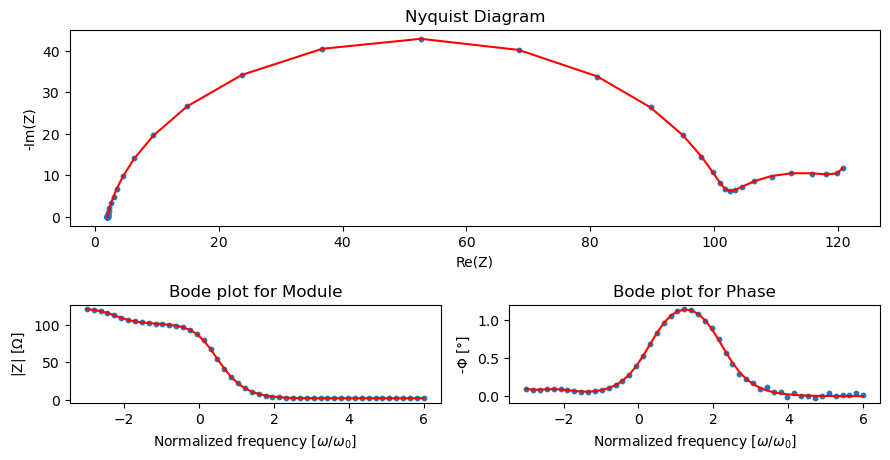

In [9]:
fig = plt.figure(figsize = (9, 6))
gs = gridspec.GridSpec(3, 2, height_ratios = [3, 1.5, 1.5], width_ratios = [1, 1])

# Nyquist Diagram
fig1 = fig.add_subplot(gs[0, :])
fig1.scatter(Z_real_exp, -Z_imag_exp, marker = 'o', s = 10)
fig1.plot(Z_real_fit, -Z_imag_fit, color = 'red')
fig1.set_title('Nyquist Diagram')
fig1.set_xlabel('Re(Z)')
fig1.set_ylabel('-Im(Z)')

# Bode plot for Module
fig2 = fig.add_subplot(gs[1, 0])
fig2.scatter(f_exp_log, mod_exp, marker = 'o', s = 10)
fig2.plot(f_exp_log, mod_fit,  color = 'red')
fig2.set_title('Bode plot for Module')
plt.xlabel('Normalized frequency [$\omega/\omega_0$]')
plt.ylabel('|Z| [$\Omega$]')

# Bode plot for Phase
fig3 = fig.add_subplot(gs[1, 1])
fig3.scatter(f_exp_log, -ph_exp, marker = 'o', s = 10)
fig3.plot(f_exp_log, -ph_fit,  color = 'red')
fig3.set_title('Bode plot for Phase')
plt.xlabel('Normalized frequency [$\omega/\omega_0$]')
plt.ylabel('-$\Phi$ [°]')

fig.tight_layout()
plt.show()

# Save the plot as a JPEG image in "Image" folder
if not os.path.exists('Image'):
    os.makedirs('Image')

fig.savefig('Image/EISfit.jpg', format='jpeg', dpi=300)

## Error evaluation
The final step is the visualization of the errors in frequency domain.

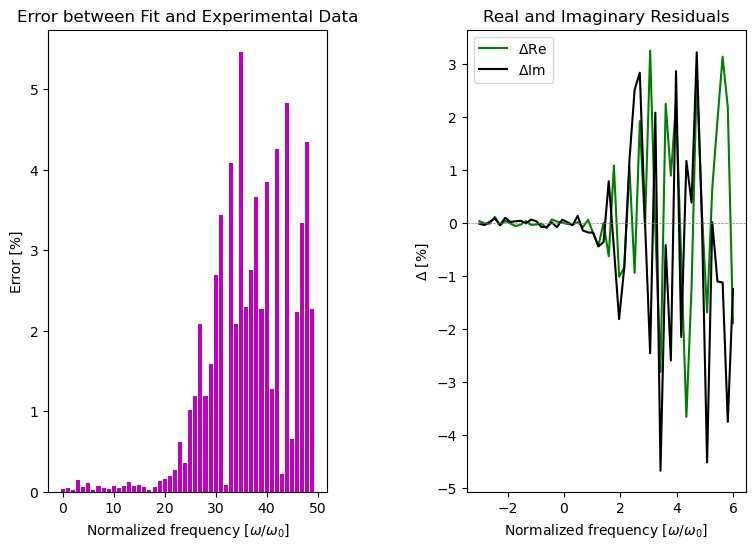

In [10]:
# Error evaluation
error = np.abs(Z_fit - Z_exp)/np.abs(Z_exp)*100

# Residuals evaluation
res_real = (Z_exp - Z_fit).real/np.abs(Z_exp)*100
res_imag = (Z_exp - Z_fit).imag/np.abs(Z_exp)*100

fig = plt.figure(figsize=(9, 6))
gs = gridspec.GridSpec(1, 2,  width_ratios=[1, 1])

# Plot the error 
fig1 = fig.add_subplot(gs[0, 0])
bar_width = 0.8
bar_positions = np.arange(len(f_exp_log))
fig1.bar(bar_positions, error, width=bar_width, color='m', label='Error')
fig1.set_title('Error between Fit and Experimental Data')
fig1.set_xlabel('Normalized frequency [$\omega/\omega_0$]')
fig1.set_ylabel('Error [%]')
fig1.set_ylim(bottom=0)

# Plot the residuals
fig2 = fig.add_subplot(gs[0, 1])
fig2.plot(f_exp_log, res_real, 'g-', label='$\Delta$Re')
fig2.plot(f_exp_log, res_imag, 'k-', label='$\Delta$Im')
fig2.set_title('Real and Imaginary Residuals')
fig2.set_xlabel('Normalized frequency [$\omega/\omega_0$]')
fig2.set_ylabel('$\Delta$ [%]')
fig2.axhline(0, color='gray', linestyle='dashed', linewidth=0.5)
fig2.legend()

gs.update(wspace=0.5)

plt.show()

# Save the plot as a JPEG image in "Image" folder
fig.savefig('Image/err.jpg', format='jpeg', dpi=300)

As expected, the larger error bars are concentrated at high frequencies, where effects due to equipment, cables, and measurement instrumentation come into play. By observing the Nyquist and Bode plots, the residual plots, and evaluating the optimized parameters and their standard deviation errors, it can be argued that the fitting process was successful. If not, it will be necessary to change the electric model, finding one that better approximates the curve.

The $\textit{impedance}$ method in Python is comparable to NLLS in MATLAB. However, Python requires fewer precautions and the code is more streamlined compared to MATLAB, making Python the best choice.

## Fitting code with $\textit{scipy}$
Now, to test two different methodologies, we also propose for Python a non-linear least squares fit based on a mathematical method with the extended equation of the electrical circuit, how to do it for MATLAB. Then, we compare it with the results obtained from $\textit{impedance}$.

By default, fitting is performed by non-linear least squares fit of the circuit model to impedance data via $\textit{leastsq}$ from the $\textit{scipy.optimize}$ package. Real and imaginary components are fit simultaneously with uniform weighting. Since we are dealing with complex number, the objective function to minimize is:

$$\chi^2 = \sum_{n=0}^{N} [Re(Z_{exp}) - Re(Z_{sim})]^2+[(Im(Z_{exp}) - Im(Z_{sim})]^2$$

The $\textit{leastsq}$ function implements the Levenberg-Marquardt algorithm, which is commonly used to solve NLLS minimization problems. This algorithm is particularly suitable for fitting experimental data using an objective function involving least squares, as is the case with the EIS fit.

Optimal parameters:  [ 1.80854806e+03 -1.80436224e+03 -1.21587145e-06  8.60637583e-01
 -3.08023699e+04 -2.28910850e-01  4.70668213e+00  1.00000000e-03
  9.00000000e-01]


C:\Users\strad_bx3\anaconda3\lib\site-packages\impedance\models\circuits\elements.py:170: RuntimeWarning: overflow encountered in tanh
  Z = Z0 / (np.sqrt(1j * omega * tau) * np.tanh(np.sqrt(1j * omega * tau)))


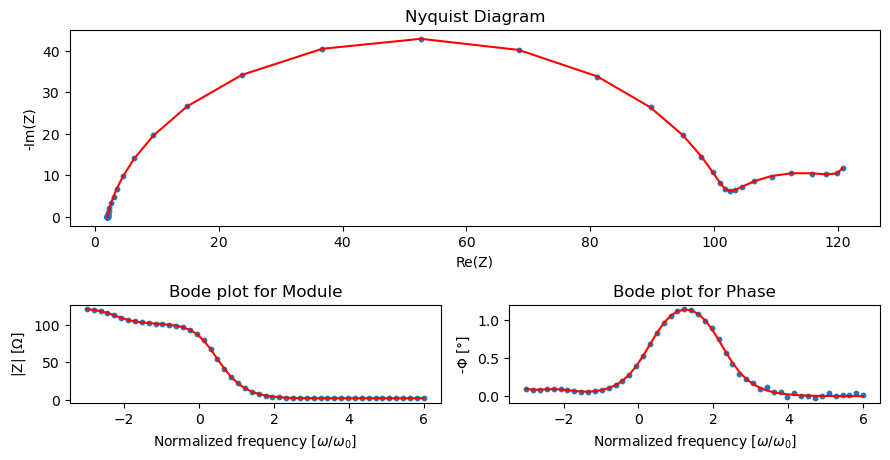

In [11]:
def objective_function(params, frequencies, Z_real_exp, Z_imag_exp):
    '''
    Function to simulate EIS with generated parameters and to evaluate the ojective function

    INPUT: params: electric parameters (R, C, L, etc.)
           requencies: frequency points

    OUTPUT: resoduals: residuals between experimental data and simulated data
    '''
    
    omega = 2 * np.pi * frequencies
    Z_sim = params[0] + 1/(1/(params[1] + (params[2]*(1j * omega)**params[3])) + 1/(params[4] + (params[5] * (1j * omega)**params[6])))
    
    Z_real_sim = Z_sim.real
    Z_imag_sim = Z_sim.imag

    residuals = np.concatenate((Z_real_exp - Z_real_sim, Z_imag_exp - Z_imag_sim))

    return residuals

# Initial parameter values
initial_params = params_gen

# Perform the Levenberg-Marquardt optimization
result = leastsq(objective_function, initial_params, args=(f_exp, Z_real_exp, Z_imag_exp))

optimized_params = result[0]
print("Optimal parameters: ", optimized_params)

# Evaluate EIS with optimized parameters
Z_fit_NLLS = circuit.predict(f_exp)

Z_real_fit_NLLS = Z_fit_NLLS.real
Z_imag_fit_NLLS = Z_fit_NLLS.imag
mod_fit_NLLS = np.abs(Z_fit_NLLS)
ph_fit_NLLS = np.angle(Z_fit_NLLS)

fig = plt.figure(figsize = (9, 6))
gs = gridspec.GridSpec(3, 2, height_ratios = [3, 1.5, 1.5], width_ratios = [1, 1])

# Nyquist Diagram
fig1 = fig.add_subplot(gs[0, :])
fig1.scatter(Z_real_exp, -Z_imag_exp, marker = 'o', s = 10)
fig1.plot(Z_real_fit_NLLS, -Z_imag_fit_NLLS, color = 'red')
fig1.set_title('Nyquist Diagram')
fig1.set_xlabel('Re(Z)')
fig1.set_ylabel('-Im(Z)')

# Bode plot for Module
fig2 = fig.add_subplot(gs[1, 0])
fig2.scatter(f_exp_log, mod_exp, marker = 'o', s = 10)
fig2.plot(f_exp_log, mod_fit_NLLS,  color = 'red')
fig2.set_title('Bode plot for Module')
plt.xlabel('Normalized frequency [$\omega/\omega_0$]')
plt.ylabel('|Z| [$\Omega$]')

# Bode plot for Phase
fig3 = fig.add_subplot(gs[1, 1])
fig3.scatter(f_exp_log, -ph_exp, marker = 'o', s = 10)
fig3.plot(f_exp_log, -ph_fit_NLLS,  color = 'red')
fig3.set_title('Bode plot for Phase')
plt.xlabel('Normalized frequency [$\omega/\omega_0$]')
plt.ylabel('-$\Phi$ [°]')

fig.tight_layout()
plt.show()

As you can see, the objective function is minimized, however the parameters are not optimized. This is because, proceeding with this method, we do not know the weight that the minimization gives on the parameters. As a result, numerical values have no physical meaning. Also, just like in MATLAB, NLLS is very sensitive to the initial values and to how you write the electrical circuit equation to fit the data. This makes this method problematic, even with a fairly standard electrical model. In conclusion, it can be argued that fitting via the $\textit{impedance}$ package remains the best solution in Python.

## Save the fit parameters

It is important to save the data in order to post-process the results. Two files will be saved: one for the optimized parameters, the second for the EIS values after the fit.

Figures are already saved after every plot, in a proper folder.

In [12]:
# Create a directory named "Results" within the current working directory
if not os.path.exists('Results'):
    os.makedirs('Results')

# Define the file paths for saving fit parameters and fit EIS
parameter_file = 'Results/fit_parameters.txt'
eis_file = 'Results/fit_eis.txt'

# Save fit parameter in .txt file
np.savetxt(parameter_file, np.array([circuit]), fmt='%s')

# Save fit EIS in .txt file
table = np.column_stack((f_exp, Z_real_fit, -Z_imag_fit))
np.savetxt(eis_file, table)